# Fantasy Football Draft Guide

In [1]:
# Import libraries
from utils import *
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from warnings import simplefilter
from datetime import *

# Configure Pandas settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

# Set pbp data read option
read_local_data = False

## Data Imports

In [2]:
# Set filepath for config yaml
filepath = "fantasy_config.yml"

# Read yaml and flatten
env_dict = flatten_dict(read_yaml(filepath))
env_dict

{'seasons': [2022, 2021],
 'rec_rec': 1,
 'rec_td': 6,
 'rec_yd': 0.1,
 'rec_twoPointConv': 2,
 'rush_td': 6,
 'rush_yd': 0.1,
 'rush_lostFumble': -2,
 'rush_twoPointConv': 2,
 'pass_td': 4,
 'pass_yd': 0.04,
 'pass_int': -1,
 'pass_twoPointConv': 2,
 'kick_fg_00_19': 3,
 'kick_fg_20_29': 3,
 'kick_fg_30_39': 3,
 'kick_fg_40_49': 4,
 'kick_fg_50_xx': 5,
 'kick_fg_miss': -1,
 'kick_pat_make': 1,
 'kick_pat_miss': -1,
 'def_td': 6,
 'def_sack': 1,
 'def_int': 2,
 'def_forceFum': 1,
 'def_recovFum': 2,
 'def_recovFumTD': 6,
 'def_safety': 2,
 'def_allow_00_00': 10,
 'def_allow_01_06': 7,
 'def_allow_07_13': 4,
 'def_allow_14_20': 1,
 'def_allow_21_27': 0,
 'def_allow_28_34': -1,
 'def_allow_35_xx': -4,
 'spec_td': 6,
 'spec_recovFumTD': 6,
 'spec_blockKick': 2,
 'spec_forceFum': 1,
 'spec_recovFum': 1}

In [ ]:
pbp_enrich_df = import_enrich_pbp_data(years=env_dict['seasons'], regular=True)

In [ ]:
pbp_expand_df = participation_expander(pbp_enrich_df)

In [ ]:
defense_player_columns = []
offense_player_columns = []
for i in range(1,12):
    defense_string = 'defense_player_'+str(i)
    offense_string = 'offense_player_'+str(i)
    defense_player_columns.extend([defense_string])
    offense_player_columns.extend([offense_string])
print(defense_player_columns,offense_player_columns)

In [ ]:
all_player_columns = defense_player_columns + offense_player_columns
all_player_columns

In [ ]:
pbp_single_game_df = pbp_enrich_df[pbp_enrich_df['game_id']=='2022_09_TEN_KC'] \
                        .sort_values(by=['play_id'], ascending=True)

def_split_df = (pbp_single_game_df['defense_players'].str.split(';', expand=True) \
                  .fillna(np.nan) \
                  .rename(columns={i: col for i,col in enumerate(defense_player_columns)}))

off_split_df = (pbp_single_game_df['offense_players'].str.split(';', expand=True) \
                  .fillna(np.nan) \
                  .rename(columns={i: col for i,col in enumerate(offense_player_columns)}))

test_df = pbp_single_game_df.join(def_split_df, how='left').join(off_split_df, how='left')

test_df

In [ ]:
test_df['season'].min()

In [ ]:
players_df = import_players_data(env_dict['seasons'])

players_df_trunc = players_df[['player_id','season','player_name','depth_chart_position']].add_prefix('p_')

players_df_trunc

In [ ]:
for column in all_player_columns:
    left_columns = ['season', column]
    right_columns = ['p_season', 'p_player_id']
    new_name = column + '_name'
    new_position = column + '_position'
    test_df = test_df.merge(players_df_trunc, how='left', left_on=left_columns, right_on=right_columns) \
                     .drop(columns=right_columns) \
                     .rename(columns={'p_player_name':new_name, 'p_depth_chart_position':new_position})

test_df

In [3]:
off_agg_df = import_off_agg_data(years=env_dict['seasons'], regular=True, level='season')
off_agg_df.sort_values(by=['season','fantasy_total_pts'], ascending=[True, False])

2022 done.
2021 done.
Downcasting floats.
Adding participation data.
Adding fantasy data.
Aggregating data.


season   player_id  fantasy_rush_pts  fantasy_rec_pts  fantasy_pass_pts  \
156     2021  00-0033908              1.80           435.70              0.00   
0       2021  00-0019596             12.50             0.00            384.64   
218     2021  00-0034857             59.10             0.00            320.28   
295     2021  00-0036223            285.10            88.00              0.00   
10      2021  00-0026498             -0.70             0.00            359.44   
...      ...         ...               ...              ...               ...   
482     2022  00-0033936             -0.10             0.00              0.00   
1197    2022  00-0033319              0.00             0.00             -0.12   
388     2022  00-0026197             -0.30             0.00              0.00   
433     2022  00-0032496             -0.30             0.00              0.00   
528     2022  00-0035042             -0.30             0.00              0.00   

      fantasy_total_pts  carries  rushing_yards  rushing_tds  targets  \
156              437.50     4.00          18.00          NaN   192.00   
0                397.14     7.00          14.00         2.00      NaN   
218              379.38    67.00         342.00         6.00     1.00   
295              373.10   332.00        1811.00        18.00    52.00   
10               358.74     7.00          11.00          NaN      NaN   
...                 ...      ...            ...          ...      ...   
482               -0.10      NaN            NaN          NaN      NaN   
1197              -0.12      NaN            NaN          NaN      NaN   
388               -0.30      NaN            NaN          NaN      NaN   
433               -0.30     1.00          -3.00          NaN      NaN   
528               -0.30     2.00          -3.00          NaN      NaN   

      receptions  receiving_yards  receiving_tds first_name last_name  \
156       145.00          1947.00          16.00     Cooper      Kupp   
0            NaN              NaN            NaN        Tom     Brady   
218         0.00              NaN            NaN     Joshua     Allen   
295        40.00           360.00           2.00   Jonathan    Taylor   
10           NaN              NaN            NaN       John  Stafford   
...          ...              ...            ...        ...       ...   
482          NaN              NaN            NaN      Casey  Beathard   
1197         NaN              NaN            NaN        NaN       NaN   
388          NaN              NaN            NaN       Chad     Henne   
433          NaN              NaN            NaN        NaN       NaN   
528          NaN              NaN            NaN        NaN       NaN   

           player_name height  weight  years_exp draft_club  draft_number  \
156        Cooper Kupp     74  208.00       4.00         LA         69.00   
0            Tom Brady     76  225.00      21.00         NE        199.00   
218         Josh Allen     77  237.00       3.00        BUF          7.00   
295    Jonathan Taylor     70  221.00       1.00        IND         41.00   
10    Matthew Stafford     75  220.00      12.00        DET          1.00   
...                ...    ...     ...        ...        ...           ...   
482      C.J. Beathard     74  215.00       5.00         SF        104.00   
1197               NaN    NaN     NaN        NaN        NaN           NaN   
388         Chad Henne     75  222.00      14.00        MIA         57.00   
433                NaN    NaN     NaN        NaN        NaN           NaN   
528                NaN    NaN     NaN        NaN        NaN           NaN   

      age_sos position depth_chart_position  jersey_number  
156     28.00       WR                   WR          10.00  
0       44.00       QB                   QB          12.00  
218     25.00       QB                   QB          17.00  
295     22.00       RB                   RB          28.00  
10      33.00       QB                   QB      

In [ ]:
# pbp_fantasy_df[pbp_fantasy_df['game_id']=='2022_09_TEN_KC'].sort_values(by=['play_id'], ascending=True) \
#     .to_csv(path_or_buf='data/pbp_fantasy_2022_09_TEN_KC.csv')

In [ ]:
# ngs_rush_df = nfl.import_ngs_data(stat_type='rushing', years=env_dict['seasons'])
# ngs_rec_df = nfl.import_ngs_data(stat_type='receiving', years=env_dict['seasons'])
# ngs_pass_df = nfl.import_ngs_data(stat_type='passing', years=env_dict['seasons'])

In [ ]:
# ngs_rush_df[(ngs_rush_df['week']==0)&(ngs_rush_df['season_type']=='REG')] \
#     .sort_values(by=['season','rush_yards_over_expected_per_att'],ascending=[False,False]).head(200)

In [ ]:
# snap_counts_df = nfl.import_snap_counts(env_dict['seasons'])
# snap_counts_df

In [ ]:
# combine_df = nfl.import_combine_data(years=env_dict['seasons'])
# combine_df

In [4]:
# Enrich off_agg_df
off_agg_df['fantasy_total_pts'] = off_agg_df['fantasy_rush_pts'] + \
                                  off_agg_df['fantasy_rec_pts'] + \
                                  off_agg_df['fantasy_pass_pts']
off_agg_df['overall_rank'] = off_agg_df.groupby('season')['fantasy_total_pts'] \
                                       .rank(method='dense', ascending=False) \
                                       .astype(int)
off_agg_df['rush_rank'] = off_agg_df.groupby('season')['fantasy_rush_pts'] \
                                    .rank(method='dense', ascending=False) \
                                    .astype(int)
off_agg_df['rec_rank'] = off_agg_df.groupby('season')['fantasy_rec_pts'] \
                                   .rank(method='dense', ascending=False) \
                                   .astype(int)
off_agg_df['pass_rank'] = off_agg_df.groupby('season')['fantasy_pass_pts'] \
                                    .rank(method='dense', ascending=False) \
                                    .astype(int)
off_agg_df['position_rank'] = off_agg_df.groupby(by=['position','season'])['fantasy_total_pts'] \
                                        .rank(method='dense', ascending=False) \
                                        .astype(int)
off_agg_df['fantasy_total_pts_nextYear'] = off_agg_df.sort_values(by=['player_id','season'], ascending=[True,False]) \
                                                     .groupby(['player_id'])['fantasy_total_pts'].shift(1)
off_agg_df['fantasy_total_pts_nextYearDiff'] = off_agg_df['fantasy_total_pts'] - \
                                               off_agg_df['fantasy_total_pts_nextYear']

off_agg_df[(off_agg_df['position']=='RB')&(off_agg_df['season']==2021)].sort_values(by=['position_rank'], 
                                                                                    ascending=True)

season   player_id  fantasy_rush_pts  fantasy_rec_pts  fantasy_pass_pts  \
295    2021  00-0036223            285.10            88.00              0.00   
361    2021  00-0036893            162.00           138.70              0.00   
154    2021  00-0033897            202.50            91.40              0.00   
137    2021  00-0033553            165.20            91.60              0.00   
144    2021  00-0033856            129.20           126.40              0.00   
113    2021  00-0033045            158.20            86.30              0.16   
155    2021  00-0033906            113.80           120.90              0.00   
47     2021  00-0030578             97.00           136.80              0.00   
272    2021  00-0035700            143.20            88.80              0.00   
313    2021  00-0036328            139.70            89.40              0.00   
125    2021  00-0033293            101.90           127.10              0.00   
305    2021  00-0036275             91.70           125.00              0.00   
207    2021  00-0034791            171.90            43.40              0.00   
266    2021  00-0035657            178.90            31.20              0.00   
79     2021  00-0032144            145.80            61.30              0.00   
379    2021  00-0036997            112.30            92.60              0.00   
152    2021  00-0033893            147.90            56.40              0.00   
239    2021  00-0035250            129.00            68.80              0.00   
271    2021  00-0035685            124.60            72.10              0.00   
97     2021  00-0032764            153.70            33.40              4.20   
301    2021  00-0036265            108.30            77.30              0.00   
247    2021  00-0035311             77.20            96.40              0.00   
337    2021  00-0036567            126.30            38.70              0.00   
269    2021  00-0035664             98.80            64.60              0.00   
240    2021  00-0035261             83.90            72.70              0.00   
367    2021  00-0036924             87.90            66.70              0.00   
215    2021  00-0034844             69.30            79.30              0.00   
58     2021  00-0031285             87.60            59.00              0.00   
216    2021  00-0034845            106.50            39.80              0.00   
201    2021  00-0034681             71.20            74.10              0.00   
107    2021  00-0032972             71.30            72.80              0.00   
75     2021  00-0032063             66.30            75.90              0.00   
336    2021  00-0036555             89.20            48.40              0.00   
122    2021  00-0033280             50.20            77.30              0.00   
222    2021  00-0034972             65.10            60.80              0.00   
203    2021  00-0034750            110.90            10.80              0.00   
366    2021  00-0036919             57.10            64.30              0.00   
162    2021  00-0033948             78.10            41.70              0.00   
259    2021  00-0035537             33.80            83.20              0.00   
358    2021  00-0036875             90.60            26.30              0.00   
183    2021  00-0034367             39.60            76.00              0.00   
320    2021  00-0036360             71.70            43.90              0.00   
238    2021  00-0035243             73.40            41.80              0.00   
20     2021  00-0027966             65.40            43.20              0.00   
159    2021  00-0033923             68.60            39.20              0.00   
297    2021  00-0036251             58.50            48.70              0.00   
37     2021  00-0030288             60.70            43.60              0.00   
43     2021  00-0030513             86.10            17.50              0.00   
117    2021  00-0033118             37.40            65.10              0.00   
187  

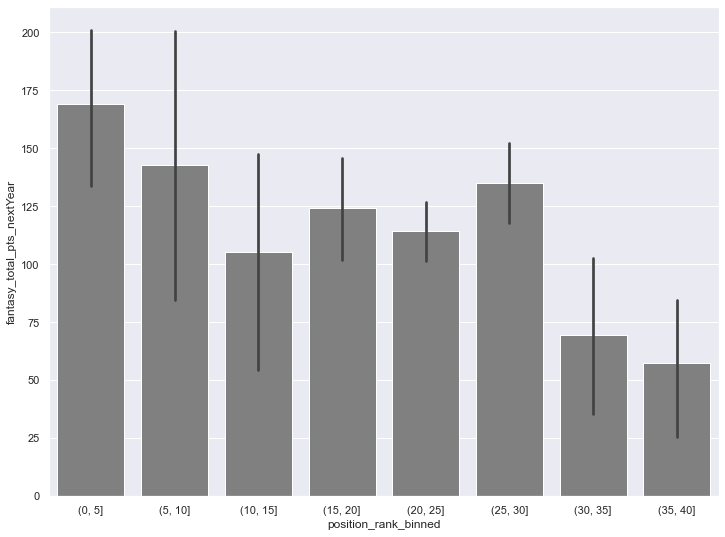

In [5]:
# Set plot parameters
plot_position = 'WR'
plot_x = 'position_rank'
plot_y = 'fantasy_total_pts_nextYear'
plot_min_x = 0
plot_max_x = 40
bin_step = 5

binning = True

#=================================================

if binning==True:
    plot_df = column_binner(
        off_agg_df[
            (off_agg_df['position'] == plot_position)& \
            (off_agg_df[plot_x] <= plot_max_x)
        ], 
        plot_x, plot_min_x, plot_max_x, bin_step
    )
    plot_x = plot_x + '_binned'
else:
    plot_df = off_agg_df[(off_agg_df['position']==plot_position)&(off_agg_df[plot_x]<=plot_max_x)]
    
sns.set(rc={'figure.figsize':(12,9)})
plot = sns.barplot(
    data=plot_df, 
    x=plot_x, 
    y=plot_y,
    color='grey'
)

In [ ]:
# plot_position = 'WR'
# plot_max_rank = 40
# g = sns.FacetGrid(off_agg_df[(off_agg_df['position_rank']<=plot_max_rank)], 
#                   col="position_rank",
#                   row="fantasy_total_pts_nextYearDiff",
#                   hue="position")
# g.map(sns.lineplot, "position_rank")

In [ ]:
# # Apply custom pivot
# values = ['fantasy_total_pts','overall_rank','position_rank','rush_rank','rec_rank','pass_rank']
# columns = ['season']
# index = ['player_id','player_name','first_name','last_name','position']
# off_agg_pivot_df = custom_pivot(off_agg_df, values, columns, index)
# off_agg_pivot_df

# for column in off_agg_pivot_df.columns:
#     if column[0:1].isdigit():
#         for sub_column in off_agg_pivot_df.columns:
#             if sub_column[0:1].isdigit():
#                 if (column[5:]==sub_column[5:])&(int(column[:4])==(int(sub_column[:4])+1)):
#                     new_col = column + '_prevDiff'
#                     off_agg_pivot_df[new_col] = off_agg_pivot_df[column] - off_agg_pivot_df[sub_column]
#                 elif (column[5:]==sub_column[5:])&((int(column[:4])+1)==int(sub_column[:4])):
#                     new_col = column + '_nextDiff'
#                     off_agg_pivot_df[new_col] = off_agg_pivot_df[column] - off_agg_pivot_df[sub_column]
#                 else: pass
#             else: pass
#     else: pass

# off_agg_melt_df = off_agg_pivot_df.melt(id_vars=index, var_name='variable')
# off_agg_filter_df = off_agg_melt_df[off_agg_melt_df['variable'].str.contains('position_rank', na=False) |
#                                     off_agg_melt_df['variable'].str.contains('pts_nextDiff', na=False) |
#                                     off_agg_melt_df['variable'].str.contains('position_rank_nextDiff', na=False)]
# off_agg_filter_df['new_variable'] = off_agg_filter_df['variable'].str[5:]
# off_agg_repivot_df = pd.pivot_table(off_agg_filter_df, values=['value'], columns=['new_variable'], index=index)
# off_agg_repivot_df = off_agg_repivot_df['value'].reset_index()
# off_agg_repivot_df

<h2>Data Exploration</h2>

In [ ]:
nfl.import_ngs_data(stat_type='rushing', years=env_dict['seasons'])

In [ ]:
nfl.import_draft_picks([2021])

In [ ]:
nfl.import_officials([2020])

In [ ]:
nfl.import_draft_values()